Can I improve miRabel by using machine learning ?

# Dataset Creation

In [242]:
import pandas as pd
import numpy as np
import pymysql.cursors
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [243]:
with open("config.cfg", "r") as cfg_file:
    username, password = [line.split(":")[1].strip() for line in cfg_file.readlines()]


In [244]:
interactions_number = 10000
# Connect to the database
connection = pymysql.connect(host='localhost',
                             user=username,
                             password=password,
                             database="mir_predictions",
                             cursorclass=pymysql.cursors.DictCursor)

with connection:
    with connection.cursor() as cursor:
        # Read a single record
        cursor.execute(f"SELECT * FROM Predictions limit {interactions_number}")
        result = cursor.fetchall()

In [245]:
df = pd.DataFrame(result)
# Remove columns with all values missing.
df.dropna(axis=1, how='all', inplace=True)
# Impute remaining missing values with the maximum value for that column.
df.fillna(df.max(), downcast='infer', inplace=True)

In [246]:
df["UTR3"] = df.apply(lambda x: 1 if x.UTR5 == 0 and x.CDS == 0 else 0, axis=1)

In [247]:
df.sort_values(by=["score"], inplace=True)

In [248]:
df.shape

(10000, 10)

In [249]:
df.head(10)

,mimat,id_g,posMiRanda,posPita,posTargetscan,score,UTR5,CDS,VALID,UTR3
4783,62,54619,6,213,46,0.046522,0,1,0,0
6466,62,84240,225,54,17,0.046579,0,0,1,1
9603,63,2628,35,137,107,0.046661,0,1,1,0
7105,62,121227,3,283,12,0.047154,0,1,1,0
5247,62,55972,44,45,254,0.047950,0,0,0,1
2430,62,8491,0,317,44,0.048381,0,1,0,0
3999,62,23670,89,82,214,0.048638,0,0,0,1
755,62,2628,36,282,107,0.049533,0,0,1,1
3313,62,10643,102,162,197,0.050097,0,0,1,1
8548,62,401265,163,101,220,0.050442,1,0,0,0


In [250]:
target = df["VALID"]
min_drop = ["mimat", "id_g", "VALID"]
max_drop = ["mimat", "id_g", "VALID", "UTR5", "CDS", "UTR3"]
data = df.drop(max_drop, axis=1)

In [251]:
target.value_counts()

0    9356
1     644
Name: VALID, dtype: int64

In [252]:
class_weights = {
    0: target.value_counts()[0]/target.shape[0], 
    1: target.value_counts()[1]/target.shape[0]
    }
class_weights

{0: 0.9356, 1: 0.0644}

## Outliers detection

In [253]:
# from sklearn.ensemble import IsolationForest
# from sklearn.model_selection import GridSearchCV

In [254]:
# data.head()

In [255]:
# parameters = {
#     'n_estimators': [500, 800],
#     'max_samples': [10], 
#     'contamination': [0.01, 0.05]
# }

# gs_outlier_remover = GridSearchCV(
#     IsolationForest(),
#     param_grid = parameters,
#     scoring="roc_auc"
# )
# gs_outlier_remover.fit(data, target)
# outliers = gs_outlier_remover.predict(data) == -1
# normal_samples = gs_outlier_remover.predict(data) == 1

In [256]:
# pd.DataFrame(gs_outlier_remover.cv_results_).sort_values(by=["rank_test_score"], ascending=True)

In [257]:
# print(gs_outlier_remover.best_estimator_)

In [258]:
# data[outliers].shape

In [259]:
# data = data[normal_samples]
# target = target[normal_samples]

In [260]:
# data.shape

# ROC analysis

In [261]:
def roc_metrics(truth, pred_score):
    fpr, tpr, threshold = roc_curve(truth, pred_score)
    specificity = 1 - fpr
    sensibility = 1 - tpr
    roc_auc = auc(specificity, sensibility)
    return (specificity, sensibility, roc_auc, threshold)

In [262]:
specificity, sensibility, roc_auc, threshold = roc_metrics(target, data["score"])

In [263]:
def plot_roc_curve(truth, pred_score, name):
    specificity, sensibility, roc_auc, threshold = roc_metrics(truth, pred_score)
    plt.figure()
    lw = 2
    plt.plot(
        specificity,
        sensibility,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Specificity")
    plt.ylabel("Sensibility")
    plt.suptitle(name)
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()

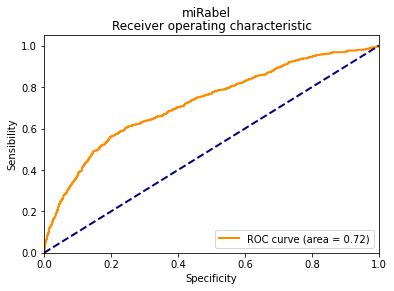

In [264]:
plot_roc_curve(target, data["score"], "miRabel")

# Feature selection

In [265]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px

In [266]:
data_std = StandardScaler().fit_transform(data)
pca = PCA()
pca.fit(data_std)

PCA()

In [267]:
explained_variance_ratios = [r for r in np.cumsum(pca.explained_variance_ratio_) if r <= 1]
px.area(
    x=range(1, len(explained_variance_ratios)+1),
    y=explained_variance_ratios,
    labels={"x": "# Components", "y": "Explained Variance"}
)

# Model selection

In [268]:
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron

In [269]:
pipeline = Pipeline([
    ("imputer", KNNImputer(n_neighbors=2)),
    ('normalizer', StandardScaler()),
    ("dimension reduction", PCA(n_components=0.9)),
    ('clf', LogisticRegression()) 
])

In [270]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.4, random_state = 42)

In [271]:
clfs = []
clfs.append(LogisticRegression(class_weight=class_weights))
clfs.append(SVC(class_weight=class_weights))
clfs.append(LinearSVC(class_weight=class_weights))
clfs.append(GaussianNB())
clfs.append(KNeighborsClassifier(n_neighbors=3))
clfs.append(DecisionTreeClassifier(class_weight=class_weights))
clfs.append(RandomForestClassifier(class_weight=class_weights))
clfs.append(GradientBoostingClassifier())
clfs.append(Perceptron(class_weight=class_weights))

results = []

for classifier in clfs:
    pipeline.set_params(clf = classifier)
    scores = cross_validate(pipeline, X_train, y_train, scoring=("roc_auc", "accuracy", "precision", "recall"), error_score="raise")

    tmp_dict = {}
    tmp_dict["classifier"] = str(classifier)
    for key, values in scores.items():
            tmp_dict[f"mean_{key}"] = values.mean()
            tmp_dict[f"std_{key}"] = values.std()
    results.append(tmp_dict)

/home/quillaur/streamlit_apps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/home/quillaur/streamlit_apps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/home/quillaur/streamlit_apps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/home/quillaur/streamlit_apps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to 

In [272]:
df_results = pd.DataFrame(results)
df_results.sort_values(by=["mean_test_roc_auc"], ascending=False)

,classifier,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_roc_auc,std_test_roc_auc,mean_test_accuracy,std_test_accuracy,mean_test_precision,std_test_precision,mean_test_recall,std_test_recall
0,"LogisticRegression(class_weight={0: 0.9356, 1:...",0.026803,0.014859,0.012468,0.003848,0.756006,0.024021,0.939000,0.000333,0.000000,0.000000,0.000000,0.000000
2,"LinearSVC(class_weight={0: 0.9356, 1: 0.0644})",0.046675,0.001686,0.005432,0.000141,0.754123,0.020871,0.939000,0.000333,0.000000,0.000000,0.000000,0.000000
3,GaussianNB(),0.003975,0.000083,0.005248,0.000166,0.747537,0.047707,0.928167,0.003391,0.293349,0.074204,0.131248,0.044049
7,GradientBoostingClassifier(),0.391869,0.018002,0.007091,0.000160,0.735888,0.038476,0.936833,0.001780,0.331429,0.123685,0.041059,0.022967
6,RandomForestClassifier(class_weight={0: 0.9356...,0.493712,0.026813,0.047558,0.001797,0.690395,0.026874,0.928167,0.003629,0.212264,0.088106,0.065679,0.026670
4,KNeighborsClassifier(n_neighbors=3),0.005140,0.000178,0.032389,0.002235,0.599525,0.026590,0.928667,0.002769,0.216714,0.072177,0.065679,0.023689
5,DecisionTreeClassifier(class_weight={0: 0.9356...,0.023474,0.003461,0.005456,0.000205,0.552383,0.030122,0.893333,0.009144,0.151929,0.048287,0.164050,0.059630
1,"SVC(class_weight={0: 0.9356, 1: 0.0644})",0.089916,0.028997,0.055095,0.001665,0.510456,0.096187,0.939000,0.000333,0.000000,0.000000,0.000000,0.000000
8,"Perceptron(class_weight={0: 0.9356, 1: 0.0644})",0.005121,0.000493,0.005207,0.000226,0.298705,0.016405,0.939000,0.000333,0.000000,0.000000,0.000000,0.000000


In [273]:
pipeline = Pipeline([
    ("imputer", KNNImputer(n_neighbors=2)),
    ('normalizer', StandardScaler()),
    ("dimension reduction", PCA(n_components=0.9)),
    ('clf', LogisticRegression()) 
])
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)
# Retain proba only for the 1 class.
y_pred = [proba[0] for proba in pipeline.predict_proba(X_test)]
y_mira = X_test["score"]

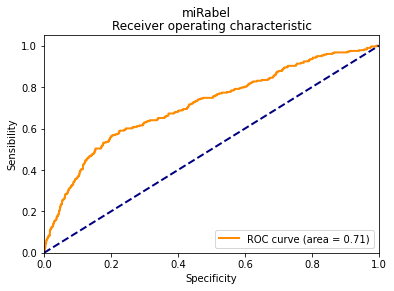

In [274]:
plot_roc_curve(y_test, y_mira, "miRabel")

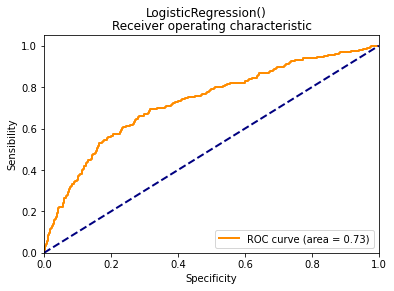

In [275]:
plot_roc_curve(y_test, y_pred, str(pipeline["clf"]))

# Tokenization

References: 
* [Bert usage with kmer tokens](https://watermark.silverchair.com/vbac023.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAucwggLjBgkqhkiG9w0BBwagggLUMIIC0AIBADCCAskGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMpGtbXy6xl6WDviyyAgEQgIICmjh3jR35GW0GTRvVJ61tCIg1Im43hAF3iRcAei1BWcOLF5r5QroUnplkPmS2nyybT7R0wlJalZjwh-YTVbSvpXjkhSWgqKY7I6DiTxttsweGoby7_sWwRI6chMG6izES19tZJEYip78ygad5aimKs500uVtBdudly_6dH-OoPhheLpJ0pHNxvmoDJvyVwJOFIK-8ai1bdE9jBY1QB6cVP4mTqjLH2nwd0vCRkdi5gIg68rhVdxavbtSuLdMdBkWLXoEx440WIQwWnld-8wLUuc2efzf_8EPZK02cHMnDD6weM9t_uBY3J9dSiKqX5kbgXKrDKLzUx7TOZJH9xlDLRSZ7GHLaYnhHSArE8YTFMnq5mCLF4WY2FHnN5Nt7ChGwD28HUiJh3MJnuOvwApv6moIVlZl5ncqcoyS5Kn1OPzLh7HzVY3nOrpIvq4FIuBsvTM8sOaVSlfM4qC4yC_rvglP8U4-RSRYlrCgI3wbi3iVc2w9qio7ePua2UwEw4s1z29SjGrFRQfjBb4kBgyEH67MsQ5JVTTRBy-Uuf7ES5TSlnVDFnIdW9zKJ1_9AX3Msz3_QolTCPkIeELk5S_rxVZaQgnyrNKQEQzvQFUk-hOpNFw04Fc-kuSBQfIxGP-NJnds9XWZw8poNsaIPNI4GhRU4rDbtFFuI5S7uQCUp-01XkEfHG7Tjex0vufWYb--QmNrbcDtxRaDLgT6zF52Q6btkwgtDRGA6Cb3hmFzaPthU4h9lSEpQcU12H-Zv6K0YonOYkA0h8ZrKYzFO3VXrVDVj9syyZrWin1PVhTjRgroEsM4k1Yo81rjZwCwqsEf3JjvycJyPtVj_ERyFDuW2o4Ka3iwcvgRBxpCQjwKsLyFx2K76ubQeuvZ7aA)
* [Another kmer tokenization exemple](https://www.biorxiv.org/content/10.1101/2020.09.17.301879v1.full.pdf)
* [Other possibilities](https://arxiv.org/pdf/2204.06699.pdf)